In [24]:
%config InlineBackend.figure_format = 'retina'
import os
from FDTD import FDTD_processing
import frgtools.misc as frgm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
mpl.rcParams.update(mpl.rcParamsDefault)
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

### Checking single experiment

Cutoff = 788.44 nm or 1.57 eV


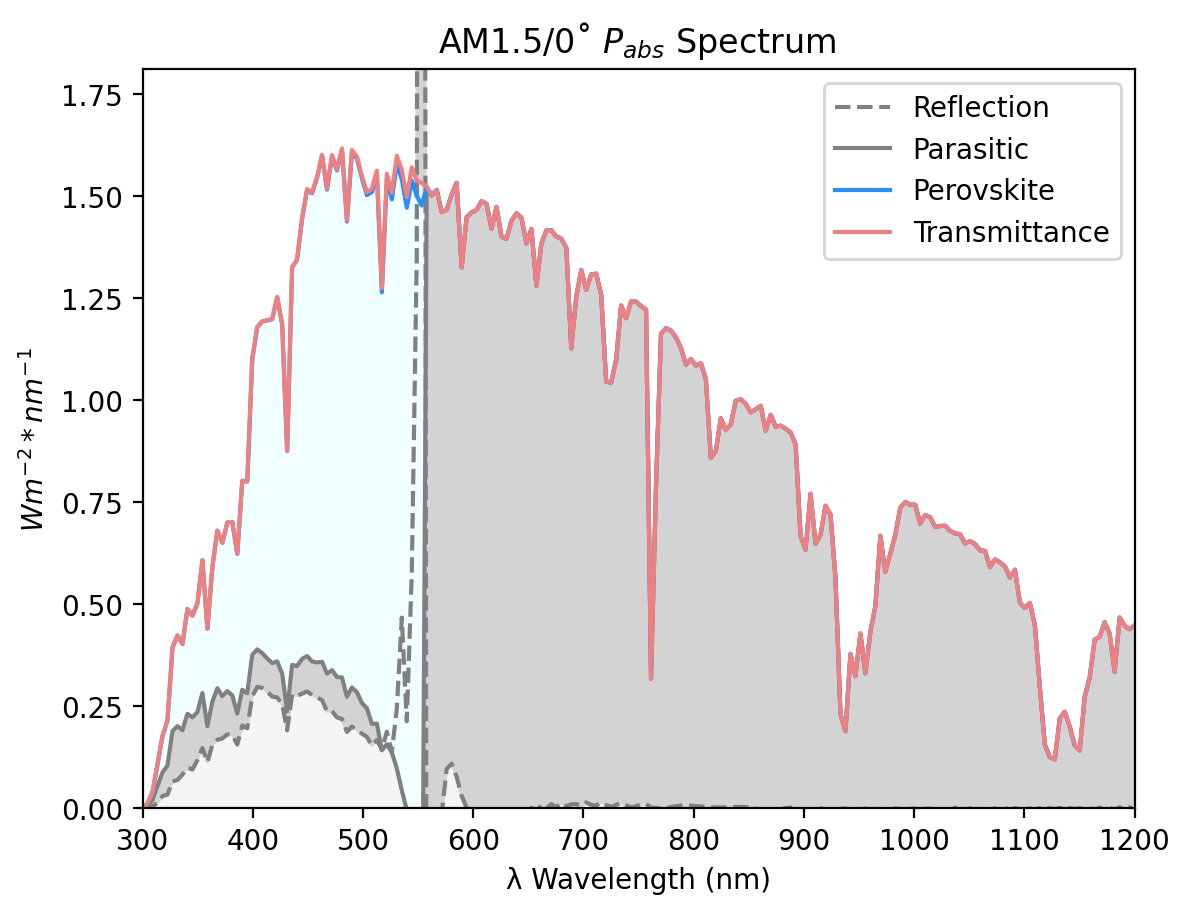

Original_AM15 = 836.09 W/m²
Rounded_AM15 = 837.1 W/m²
Error = 0.12 %
R_pabs_value = 89.58 W/m² or 10.7 %
PA_pabs_value = 531.63 W/m² or 63.51 %
PSK_pabs_value = 214.54 W/m² or 25.63 %
T_pabs_value = 1.35 W/m² or 0.16 %
Sum_pabs_error = 0.0 %


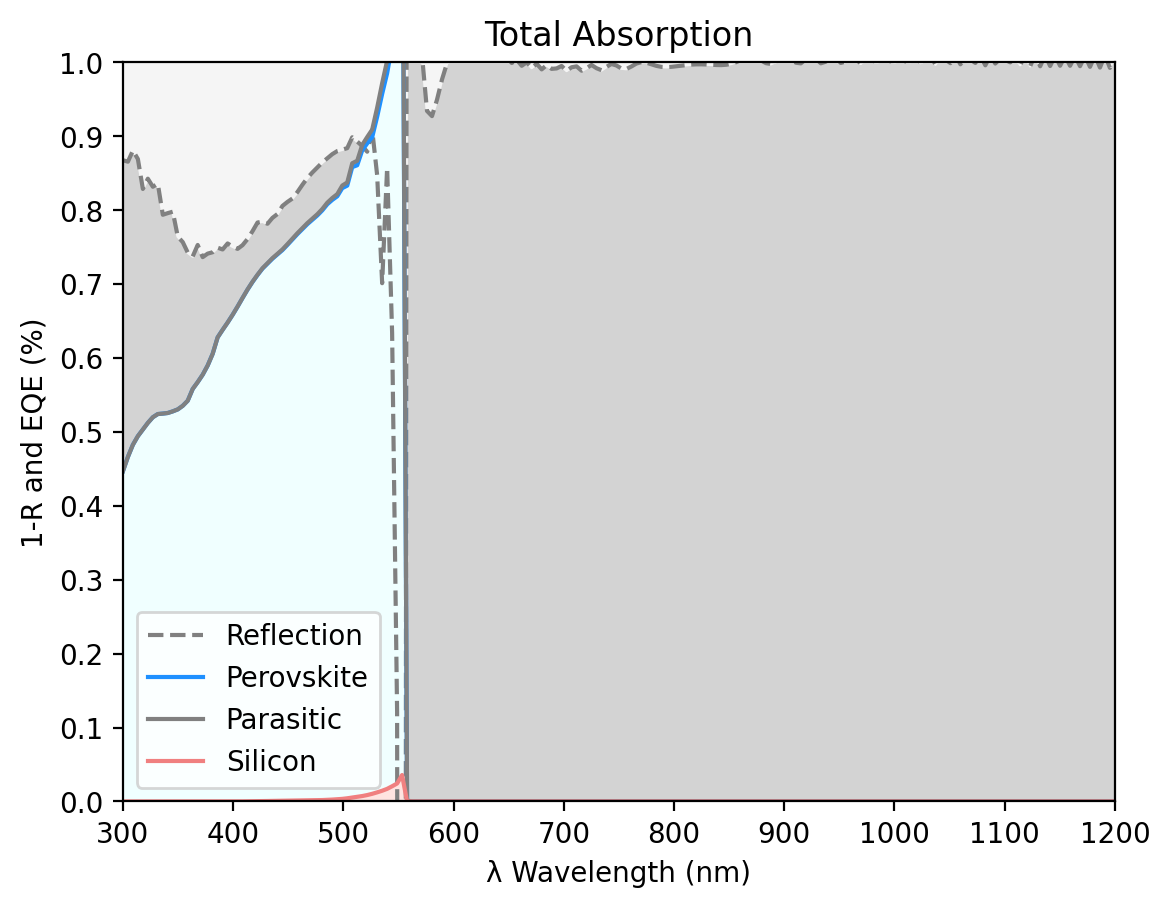

{'R_Jsc': 3.58, 'PA_Jsc': 34.69, 'PSK_Jsc': 8.17, 'Si_Jsc': 0.06}

In [29]:
#change these
FDTD_rootdir = os.path.join('FDTD_Simulation_Outputs', '20200813', '1.57eV', '300nm' ,'60theta')
Spectrum_fp = os.path.join('Spectrum_Import','AM15.csv')
RayTracing_fp = os.path.join('RT_Outputs','RAT_z0_a300_b50_c2_d3.36_e95_f95.csv')

#RAT_z0_a300_b0_c0_d0_e95_f95.csv
#RAT_z0_a300_b50_c2_d3.36_e95_f95_bottomonly.csv

#keep these
R_fp = os.path.join(FDTD_rootdir,'reflection_export.txt')
T_fp = os.path.join(FDTD_rootdir,'transmission_export.txt')
PSK_fp = os.path.join(FDTD_rootdir,'PSK_EQE.txt')
SI_fp = os.path.join(FDTD_rootdir,'Si_EQE.txt')

FDTD_processing.FDTD_load(R_fp, T_fp, PSK_fp, SI_fp, Spectrum_fp, RayTracing_fp, Gap_cutoff=108, monitor_rez=200, plot=True)

### Batch Gathering Multiple Experimens

In [3]:
fids = frgm.listdir()
fidsearch=frgm.searchdir('.', ['20200813'], ignore=['Picture','ITO','FullConformalPyramid','trans','ref','PSK','HTL', 'ETL', 'lambdaT'], match_directories=True)

In [4]:
for n in range(len(fidsearch)):
    fidsearch[n] = os.path.split(fidsearch[n])[0]
fidsearch

['/Volumes/GoogleDrive/My Drive/Optical_Simulations/FDTD_Simulation_Outputs/20200813/1.57eV/300nm/15theta',
 '/Volumes/GoogleDrive/My Drive/Optical_Simulations/FDTD_Simulation_Outputs/20200813/1.57eV/300nm/0theta']

In [8]:
fid_dict = {}
for n in tqdm(range(len(fidsearch))):
    R_fp = os.path.join(fidsearch[n],'reflection_export.txt')
    T_fp = os.path.join(fidsearch[n],'transmission_export.txt')
    PSK_fp = os.path.join(fidsearch[n],'PSK_EQE.txt')
    SI_fp = os.path.join(fidsearch[n],'Si_EQE.txt')
    Spectrum_fp = os.path.join('Spectrum_Import','AM15.csv')
    RayTracing_fp = os.path.join('RT_Outputs','RAT_z0_a300_b50_c2_d3.36_e95_f95.csv')
    


    fid_dict[n]=FDTD_processing.FDTD_load(R_fp, T_fp, PSK_fp, SI_fp, Spectrum_fp, RayTracing_fp, Gap_cutoff=108, monitor_rez=200, plot=False)
    

100%|██████████| 2/2 [00:00<00:00, 18.85it/s]


In [14]:
# adding sample descriptors manually for now... Can extract from file ID if structure is static in future...
df=[]
data = {
    'Top_Eg': [1.57, 1.57],
    'Theta':         [0,  15 ],
    'R_Jsc': [],
    'PA_Jsc': [],
    'PSK_Jsc': [],
    'Si_Jsc': [],
}
    
for n in range(len(fidsearch)):
    R_Jsc = fid_dict[n]['R_Jsc']
    PA_Jsc = fid_dict[n]['PA_Jsc']
    PSK_Jsc = fid_dict[n]['PSK_Jsc']
    Si_Jsc = fid_dict[n]['Si_Jsc']
    data['R_Jsc'].append(R_Jsc)
    data['PA_Jsc'].append(PA_Jsc)
    data['PSK_Jsc'].append(PSK_Jsc)
    data['Si_Jsc'].append(Si_Jsc)
    
df = pd.DataFrame(data)
# df

In [15]:
df

,Top_Eg,Theta,R_Jsc,PA_Jsc,PSK_Jsc,Si_Jsc
0,1.57,0,1.22,1.44,19.81,20.52
1,1.57,15,0.74,1.69,19.68,20.87


### Creating a FoM

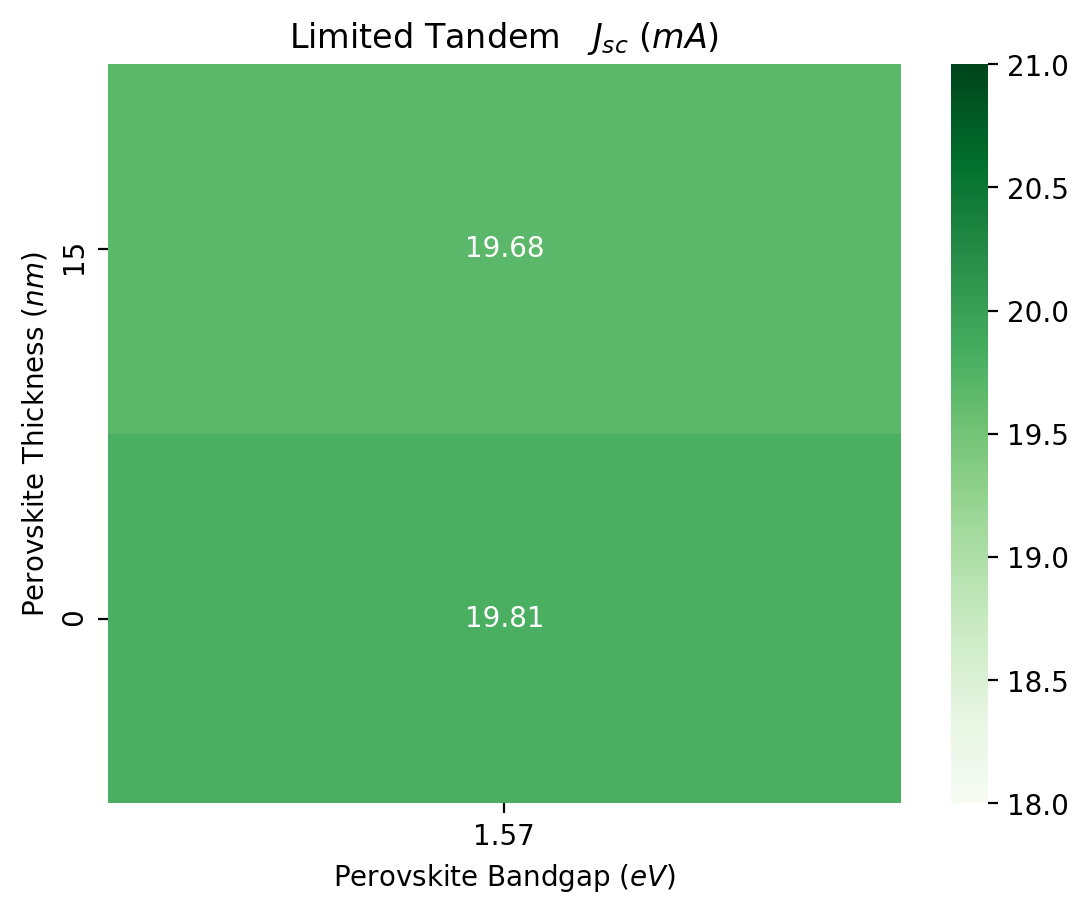

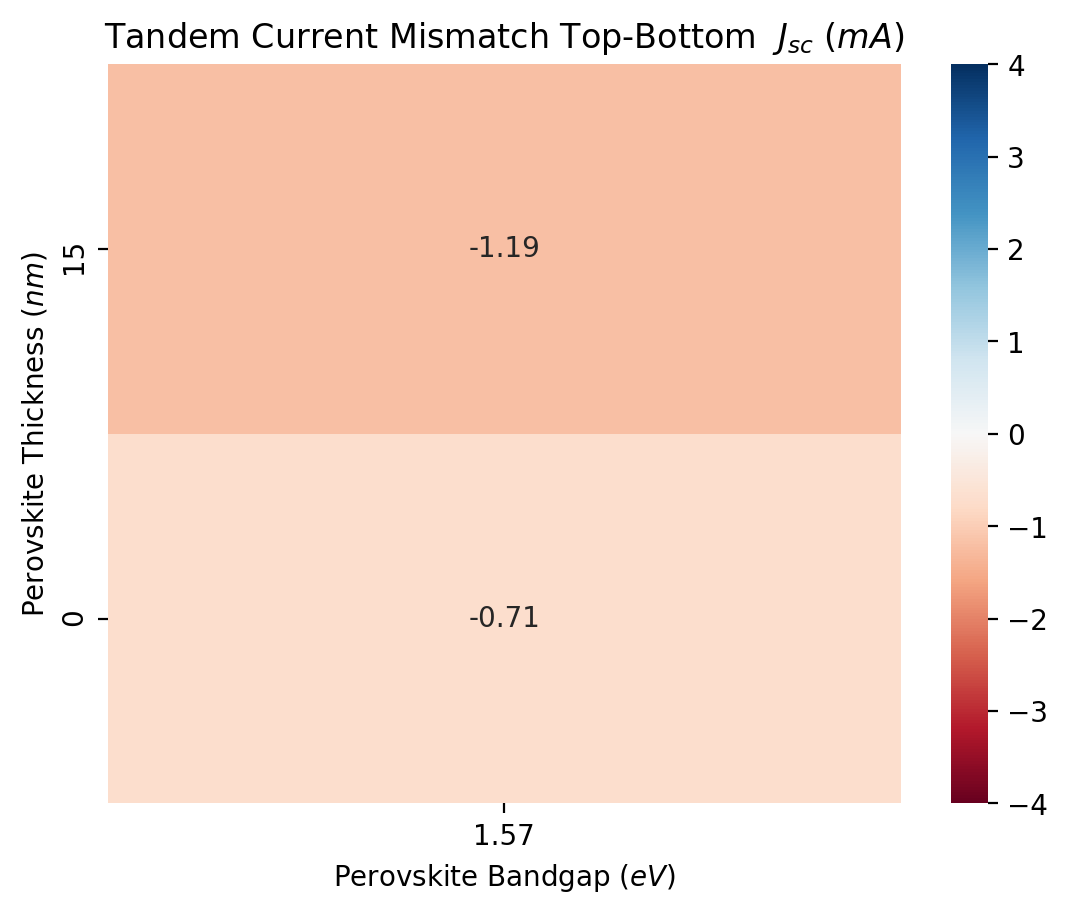

In [16]:
df['Match']= df['PSK_Jsc'] - df['Si_Jsc']
df['Total_unlimited']= df['PSK_Jsc'] + df['Si_Jsc']
df['Total_limited']=np.nan

for n in range(0, len(df)):
    a = df['PSK_Jsc'][n]
    b = df['Si_Jsc'][n]
    if a < b:
        c = a
    if a > b:
        c = b
    if a == b:
        c = a
    df['Total_limited'][n] = c

result1 = df.pivot(index = 'Theta', columns = 'Top_Eg' , values='Total_limited')
ax1=sns.heatmap(result1, annot=True, fmt ='.2f', cmap='Greens', vmin=18, vmax=21)
plt.ylabel('Perovskite Thickness $(nm)$')
plt.xlabel('Perovskite Bandgap $(eV)$')
ax1.invert_yaxis()
plt.title('Limited Tandem   $J_{sc}$ $ (mA)$')
plt.show()

result2 = df.pivot(index = 'Theta', columns = 'Top_Eg' , values='Match')
ax2 = sns.heatmap(result2, annot=True, fmt ='.2f', cmap='RdBu', vmin=-4, vmax=4)
plt.ylabel('Perovskite Thickness $(nm)$')
plt.xlabel('Perovskite Bandgap $(eV)$')
ax2.invert_yaxis()
plt.title('Tandem Current Mismatch Top-Bottom  $J_{sc}$ $ (mA)$')
plt.show()